In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import read_h5ad
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# import geneTF functions
sys.path = ["../src"] + sys.path
from pl import enhancer_plot, setup_cmap_and_legend, discretize_colors
from util import load_module

In [3]:
# @Cailin you probably have better example data that does not require R and can remove this block
module_R = "R/4.0.0-foss-2019b"  # use the R you used to install rpy2
load_module(module_R)

from rpy2.robjects import r, pandas2ri

In [4]:
n_genes = 100
min_peaks = 3
rna_annData_file = "/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/cd34_multiome_rna_no_bcells.h5ad"
atac_annData_file = "/fh/fast/setty_m/grp/lab-datasets/cd34-multiome/without-b-cells/cd34_multiome_atac_no_bcells.h5ad"
gtf_file = "/fh/fast/setty_m/grp/gtfs/hg38.gtf"
gene_peak_scores_file = (
    "/fh/fast/setty_m/user/dotto/dorc-scores/data/cd34_meta_dorc_correlations.p"
)
fate_df_file = "/fh/fast/setty_m/user/dotto/differential_expression/data/samples_cd34_multiome_rna_no_bcells.rds"
base_fate = "pluripotent"
dorc_pval = 0.05

In [5]:
rna_ad = read_h5ad(rna_annData_file)
atac_ad = read_h5ad(atac_annData_file)

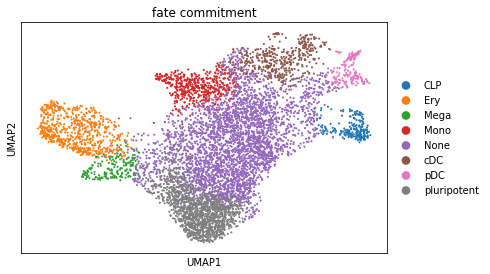

In [6]:
pandas2ri.activate()
fate_df = r.readRDS(fate_df_file)
rna_ad.obs["fate_commitment"] = fate_df["fate_commitment"]
sc.pl.scatter(rna_ad, basis="umap", color="fate_commitment")

In [7]:
with open(gene_peak_scores_file, "rb") as fl:
    gene_peak_scores = pickle.load(fl)

# Preparing data

In [8]:
cell_idx = rna_ad.obs_names[rna_ad.obs["fate_commitment"] == base_fate]
base_mean = np.mean(atac_ad[cell_idx, :].X, axis=0)

/home/dotto/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
def get_peak_deltas(fate, all_deltas, gene_peak_scores, nearest_genes):
    dorc_peak_deltas = dict()
    near_peak_deltas = dict()
    for gene in tqdm(rna_ad.var_names, desc=fate, total=rna_ad.n_vars):
        idx = nearest_genes == gene
        near_peak_deltas[gene] = all_deltas[idx].sort_values()
        dorc_peak_deltas[gene] = pd.Series(dtype="float64")
        peak_df = gene_peak_scores.get(gene)
        if peak_df is None or isinstance(peak_df, int):
            continue
        selected_peaks = peak_df[peak_df["pval"] < dorc_pval]
        if len(selected_peaks) == 0:
            continue
        dorc_peak_deltas[gene] = all_deltas[selected_peaks.index].sort_values()
    return dorc_peak_deltas, near_peak_deltas

In [10]:
fate = rna_ad.uns["palantir_branch_probs_columns"][0]
cell_idx = rna_ad.obs_names[rna_ad.obs["fate_commitment"] == fate]
fate_mean = np.mean(atac_ad[cell_idx, :].X, axis=0)
all_deltas = pd.Series(np.array(fate_mean - base_mean).ravel(), index=atac_ad.var_names)
dorc_peak_deltas, near_r = get_peak_deltas(
    fate, all_deltas, gene_peak_scores, atac_ad.var["nearestGene"]
)

cDC: 100%|██████████| 12464/12464 [00:08<00:00, 1460.34it/s]


In [11]:
# Read the RDS file for the current fate.
gene_info_df = r.readRDS(
    f"/fh/fast/setty_m/user/dotto/differential_expression/data/de_cd34_multiome_rna_no_bcells_{fate}.rds"
)
gene_info_df["logFC"] = -gene_info_df["logFC"]

# Define continuous colors from the dorc_peak_deltas for the current fate.
cont_colors = dorc_peak_deltas

# Preparing plot

In [12]:
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["figure.dpi"] = 300

# Define a dictionary for colormap and legend elements.
# This will be used for discretely coloring and grouping the data.
cmapdict = {
    "up-regulated": "#D13927",
    "unchanged": (0.7, 0.7, 0.7, 1.0),
    "down-regulated": "#4A7CB5",
}
# Call setup_cmap_and_legend function with the cmapdict to generate colormap and legend elements.
cmap, legend_elements = setup_cmap_and_legend(cmapdict)

# Define a threshold for discretizing colors.
discretize = (-0.02, 0.02)

# Call discretize_colors function to discretize the continuous colors.
# disc_colors is a dictionary of {gene: peak_group_assignments} where each gene is assigned to a peak group.
# The number of different groups is the same as the number of colors defined in cmapdict.
disc_colors = discretize_colors(dorc_peak_deltas, discretize)

# Create an enhancer plot with continuous colors

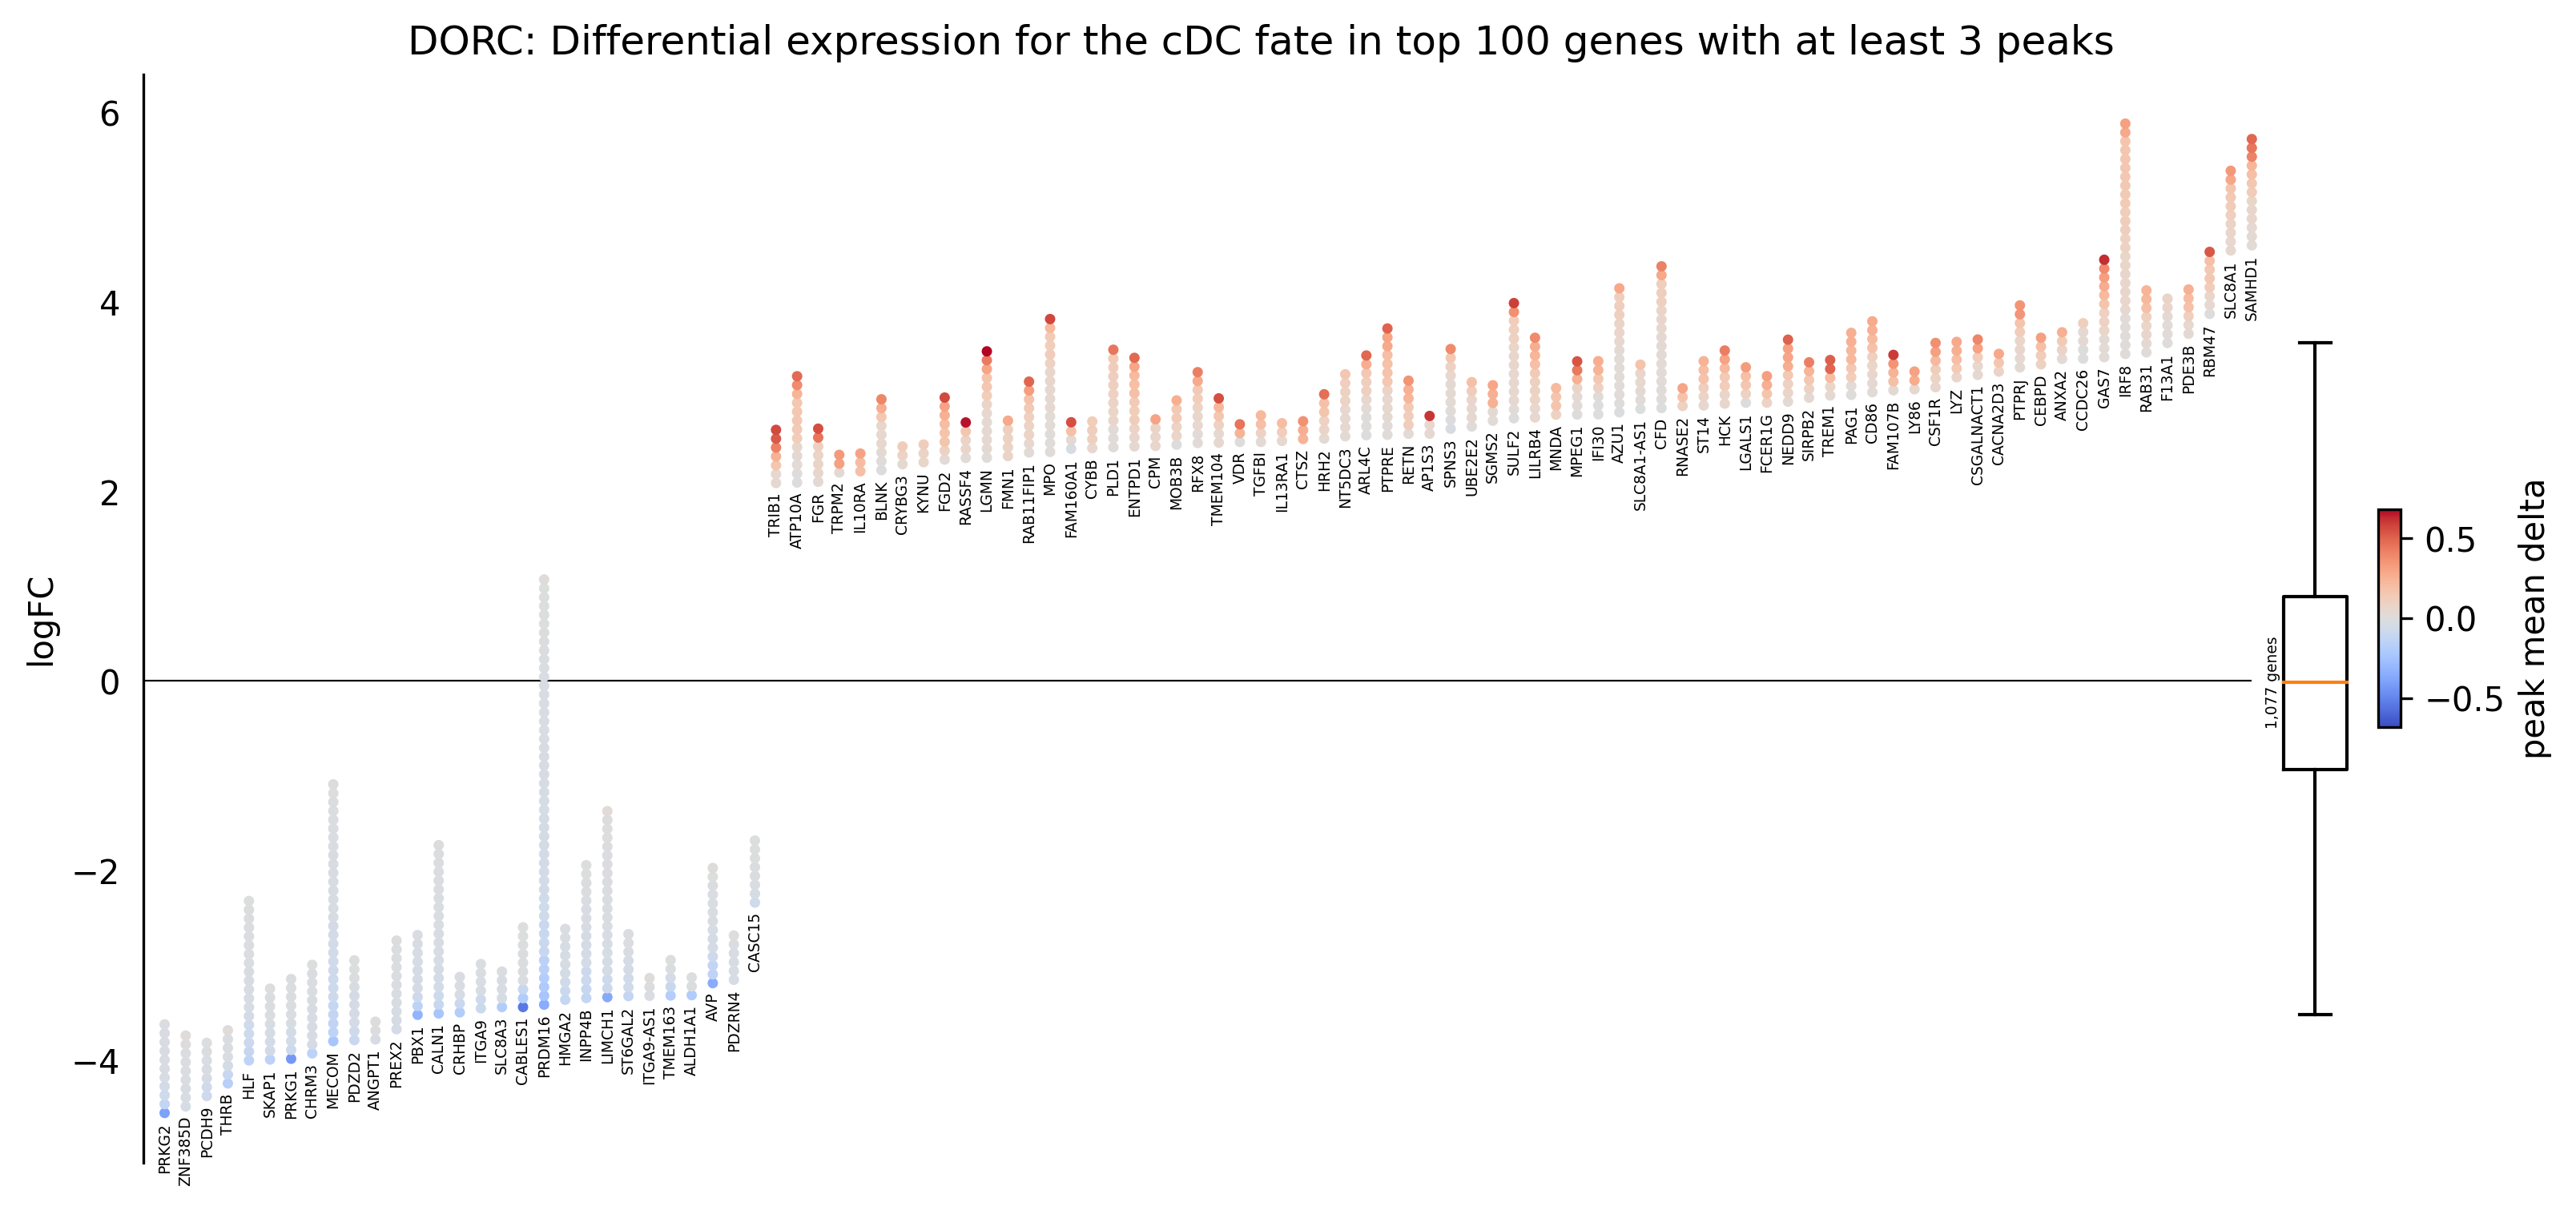

In [13]:
fig, ax, _ = enhancer_plot(
    gene_info_df, cont_colors, n_genes=n_genes, min_peaks=min_peaks
)
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create an enhancer plot with discrete colors

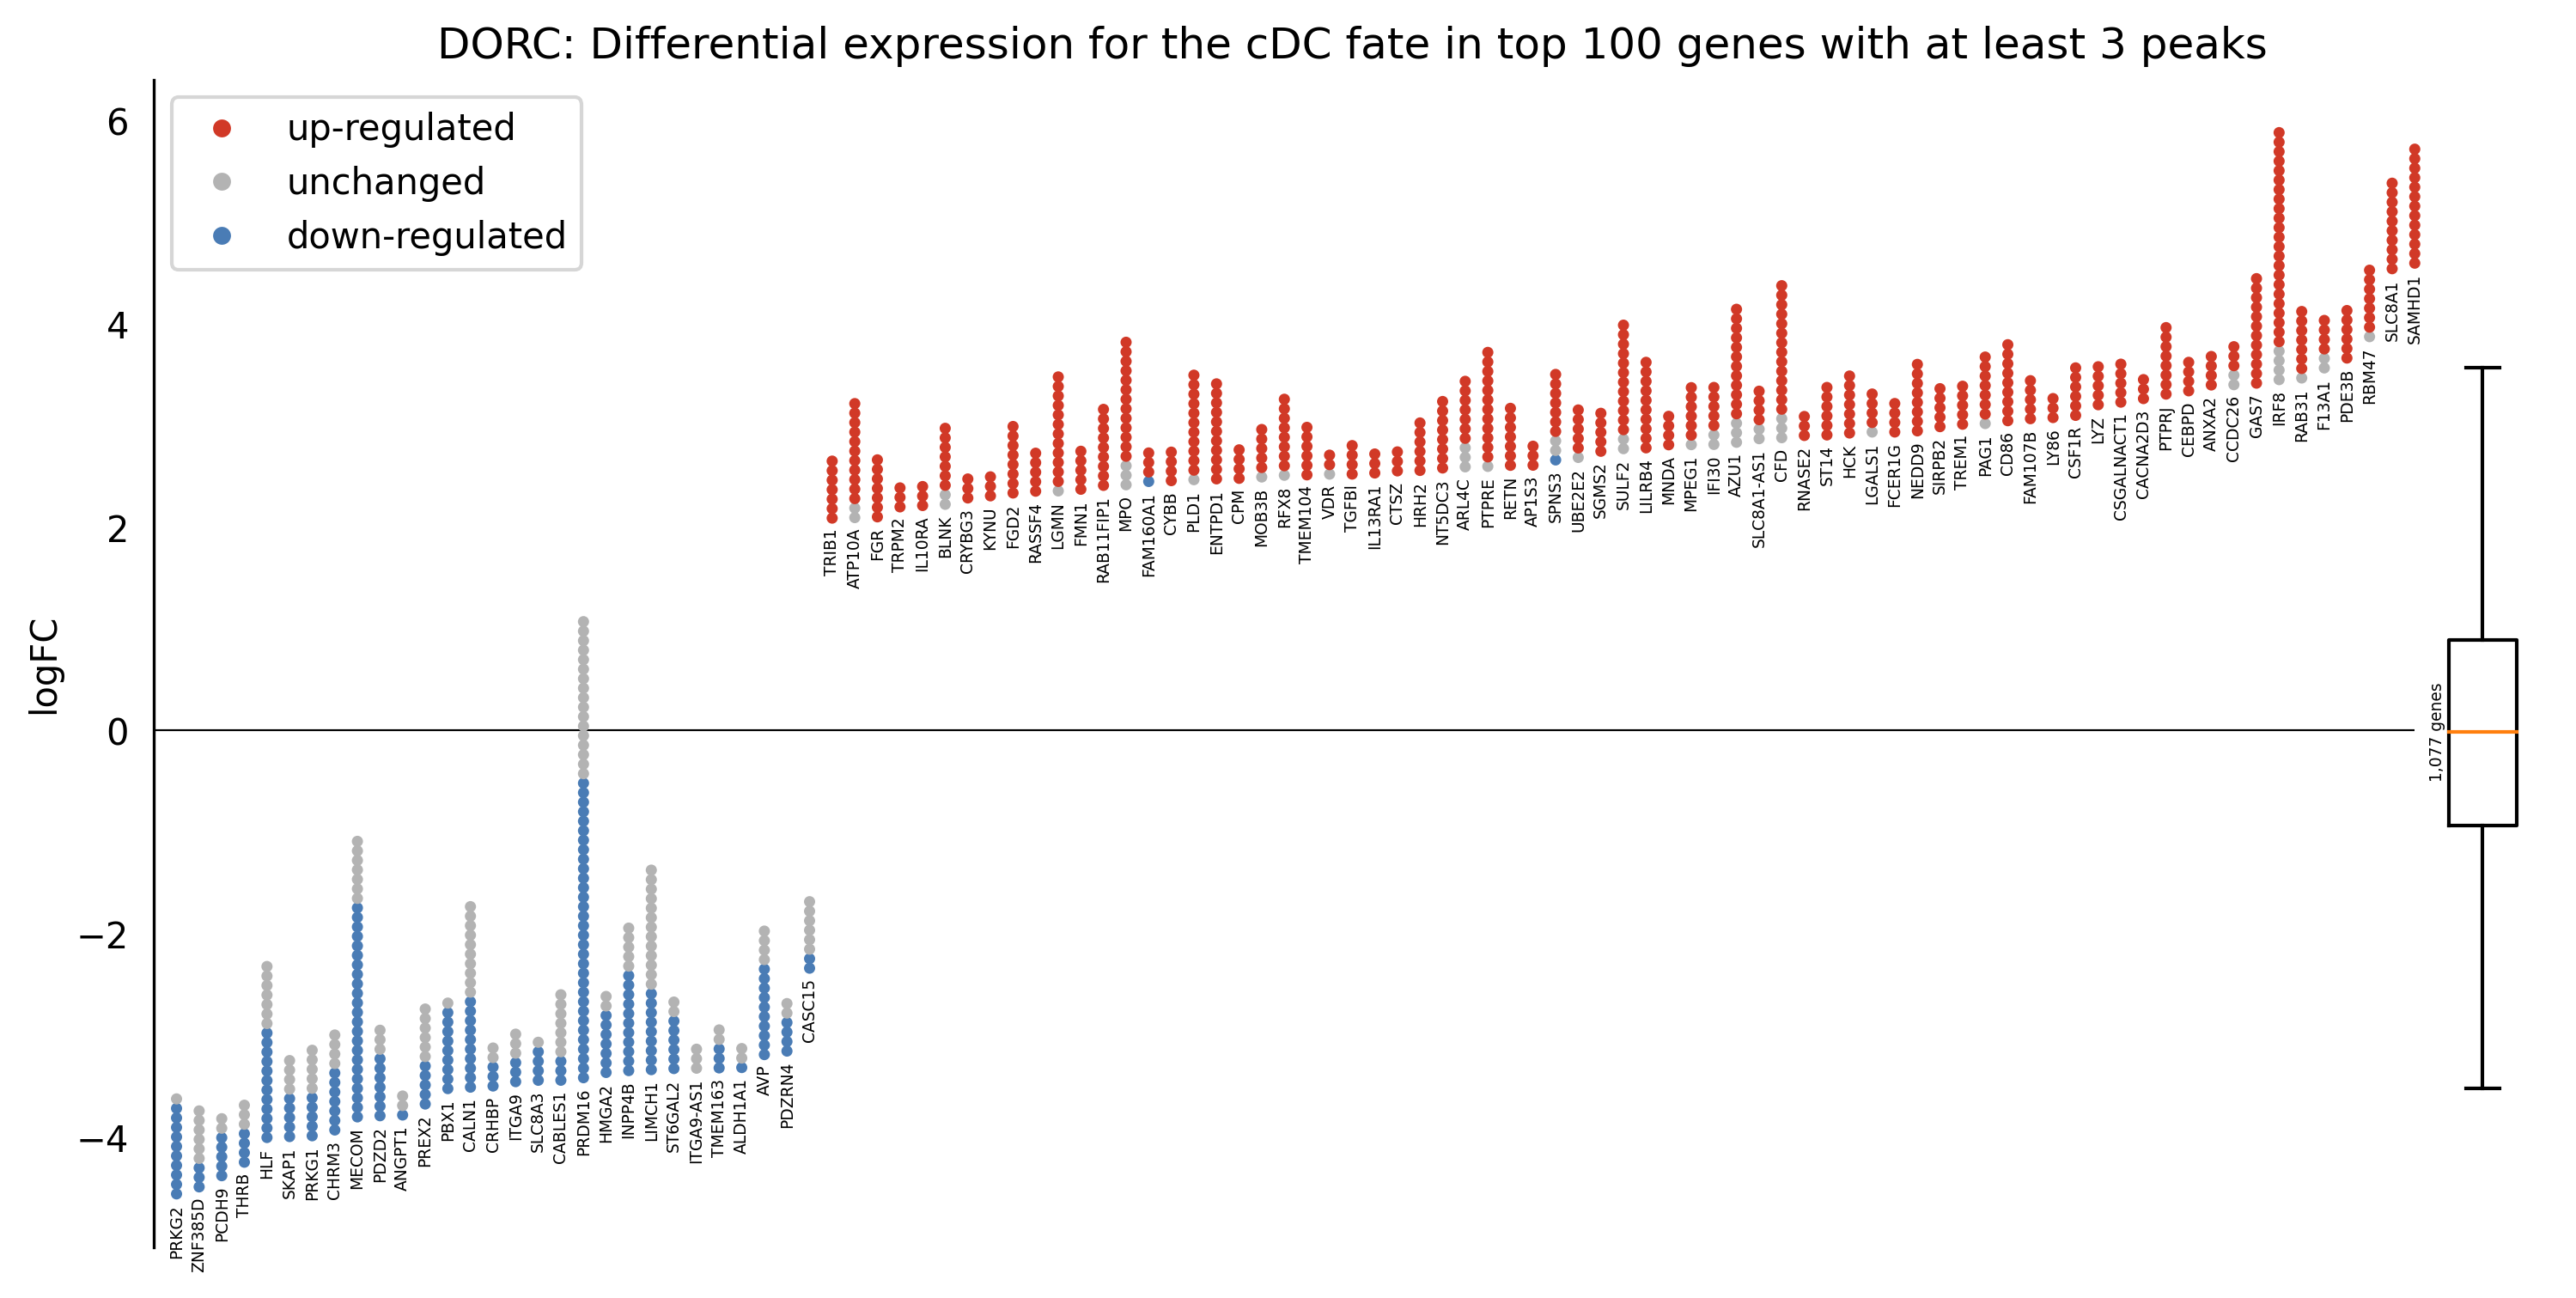

In [14]:
# Here, each gene is represented with a color based on its peak group assignment.
fig, ax, _ = enhancer_plot(
    gene_info_df, disc_colors, n_genes=n_genes, min_peaks=min_peaks, cmap=cmap
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with continuous colors

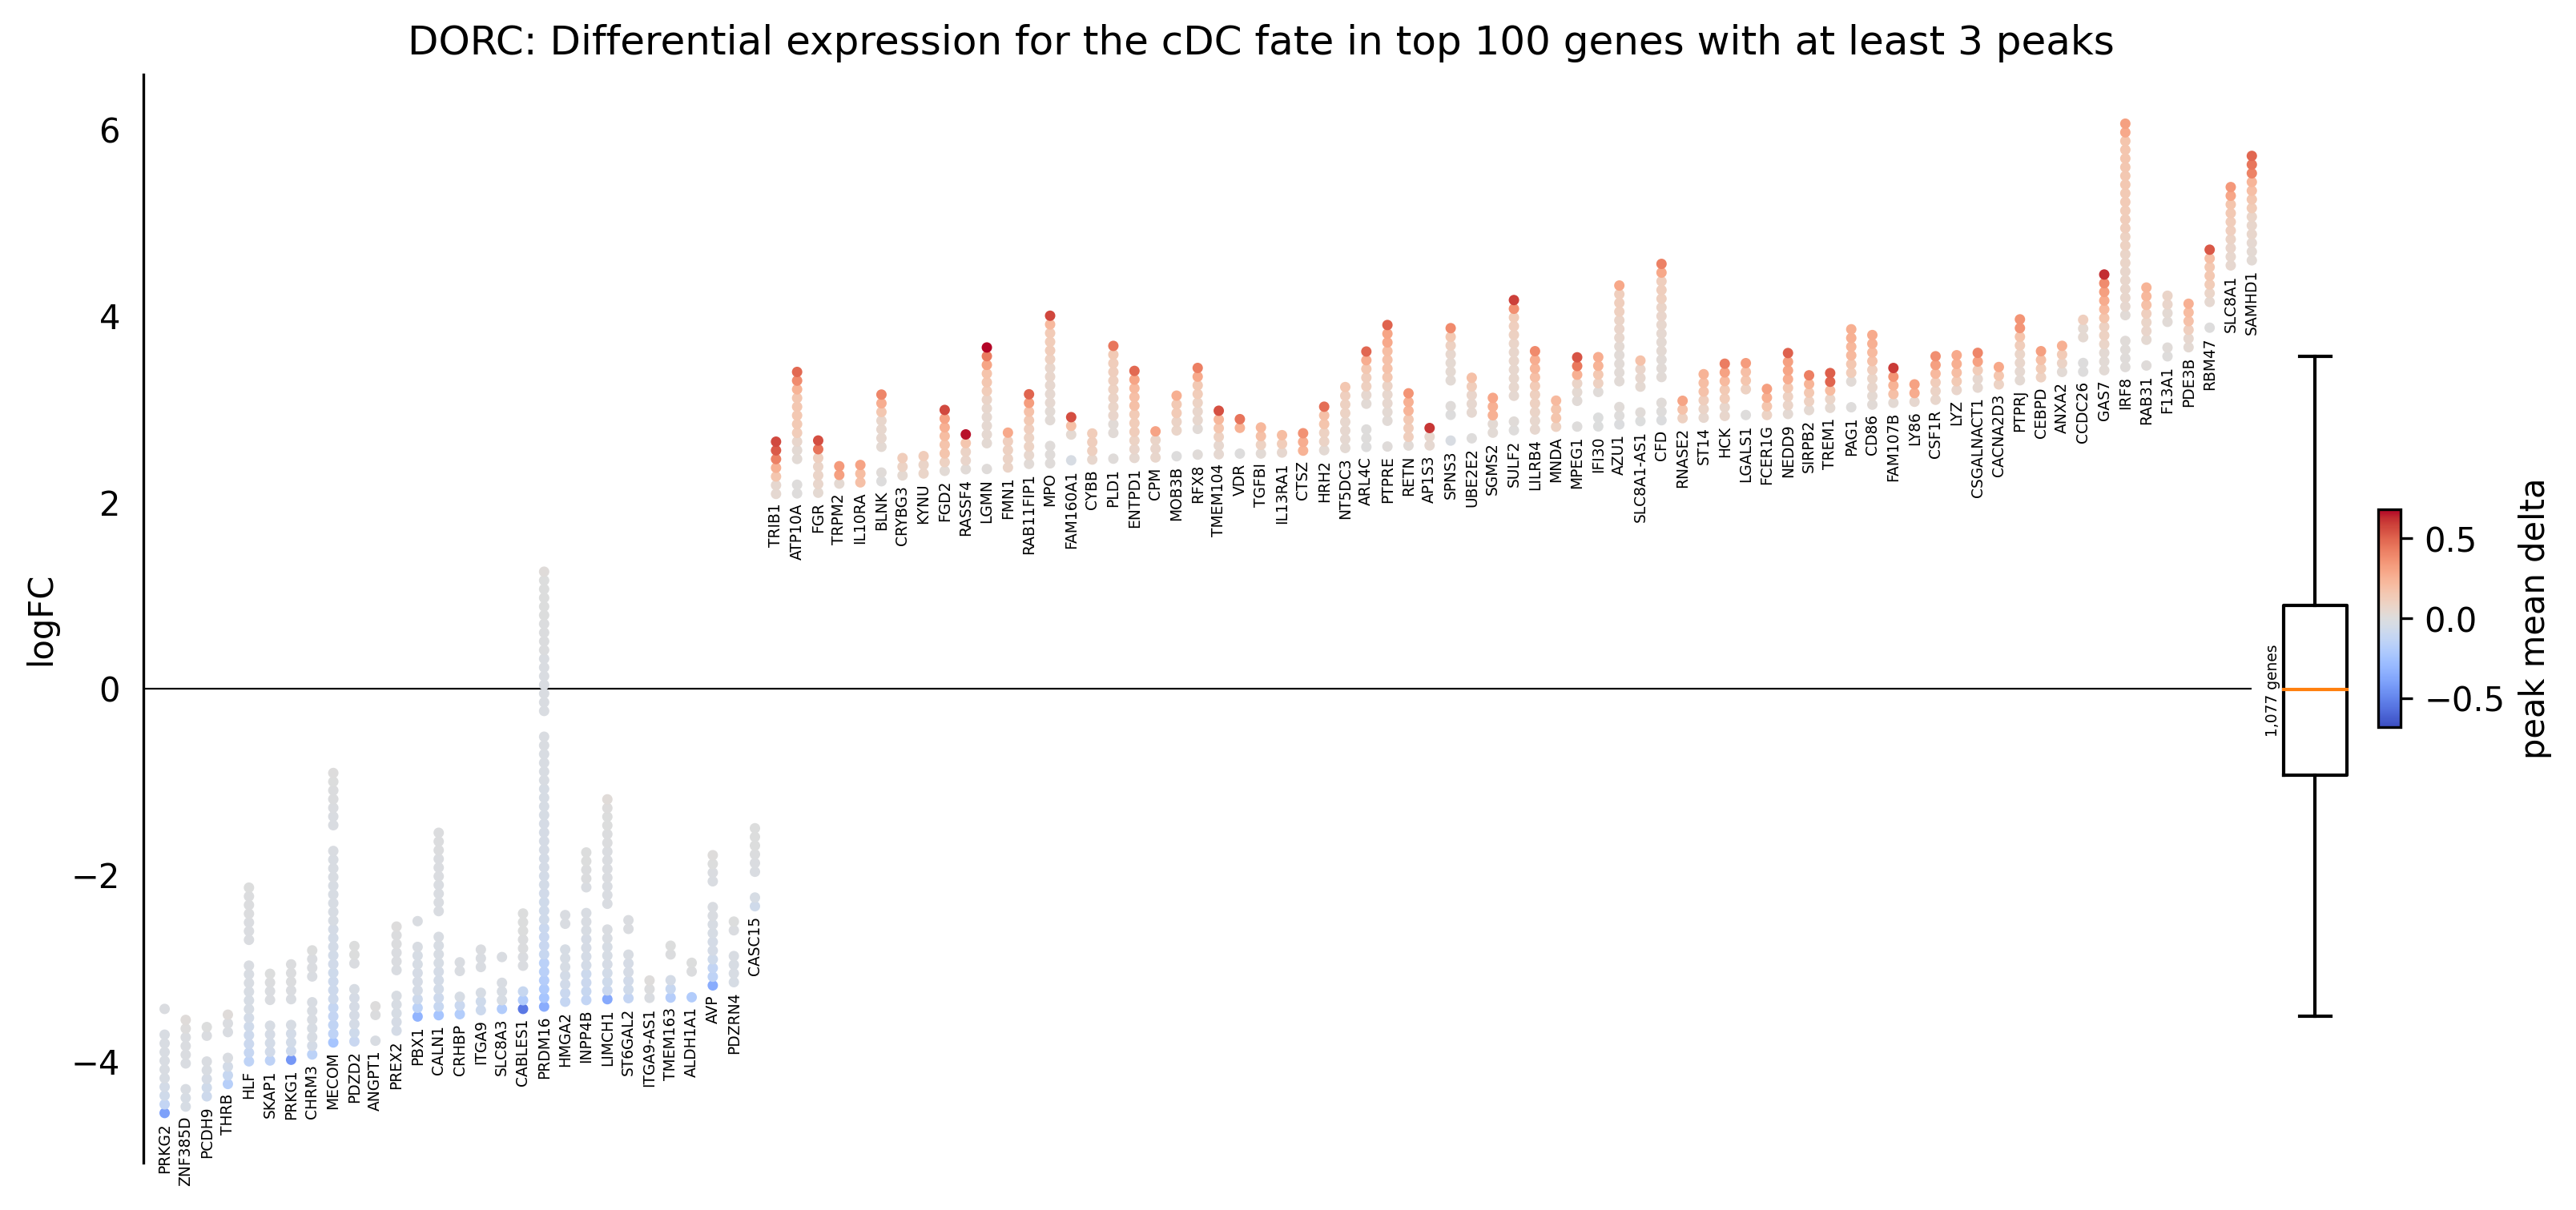

In [15]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
)
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Create a grouped enhancer plot with discrete colors

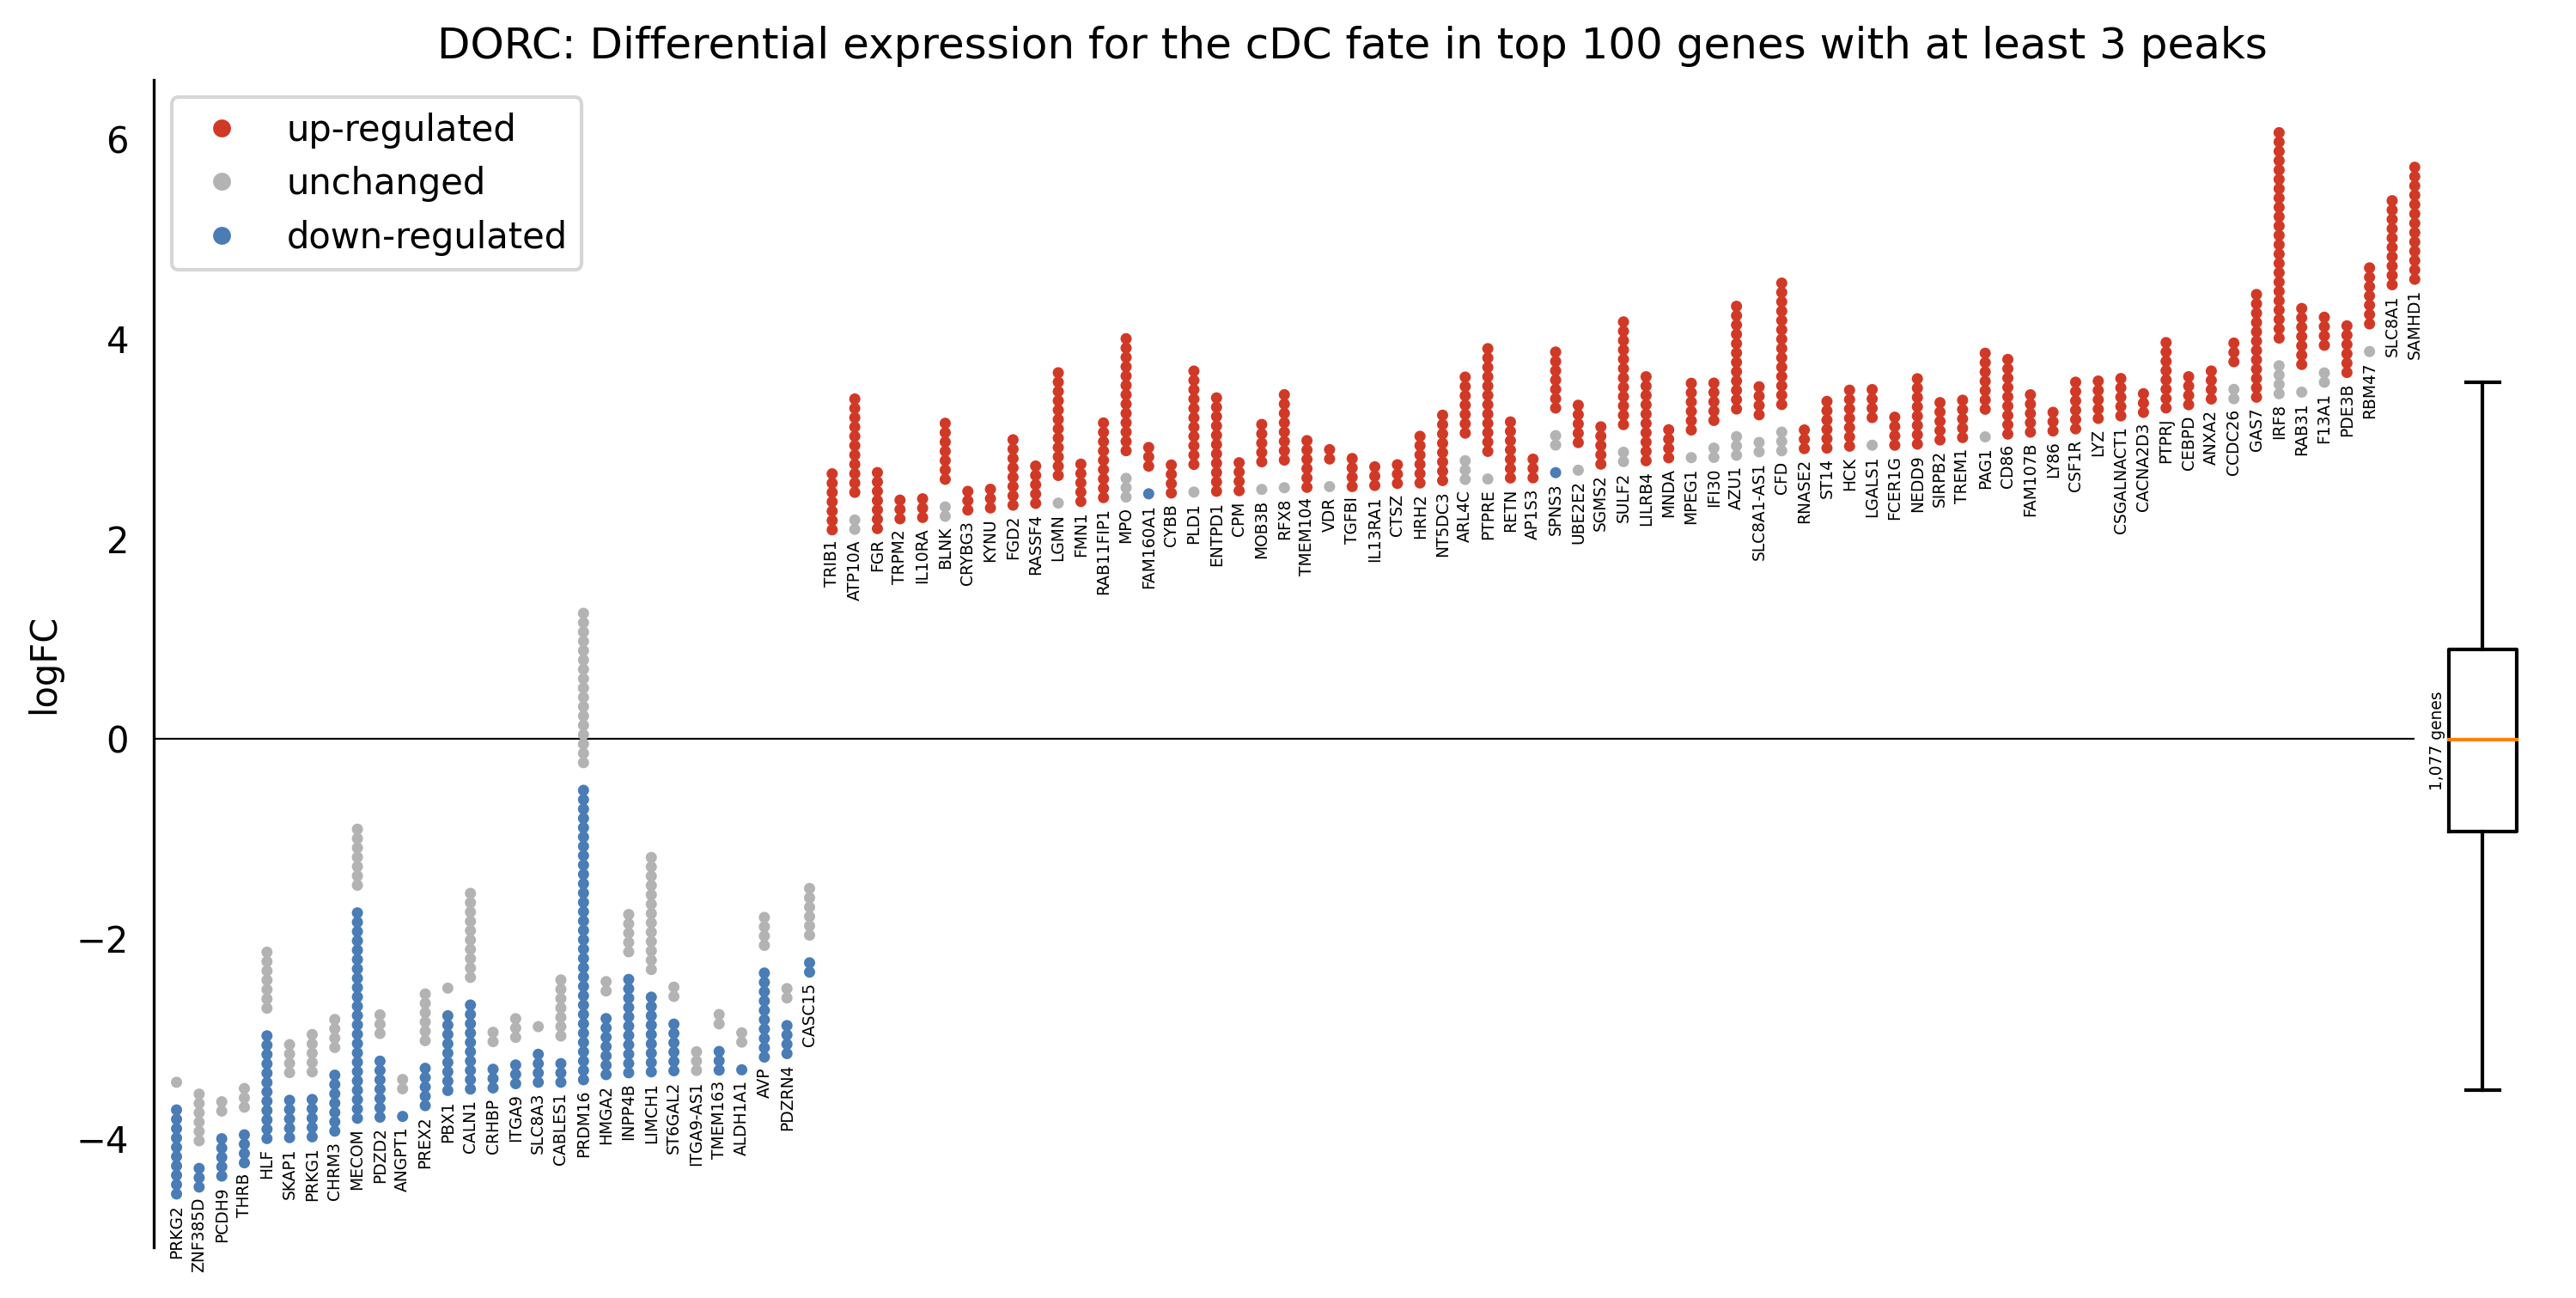

In [16]:
fig, ax, _ = enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate in top {n_genes} genes with at least {min_peaks} peaks"
)
plt.show()

# Show a custom subset of genes

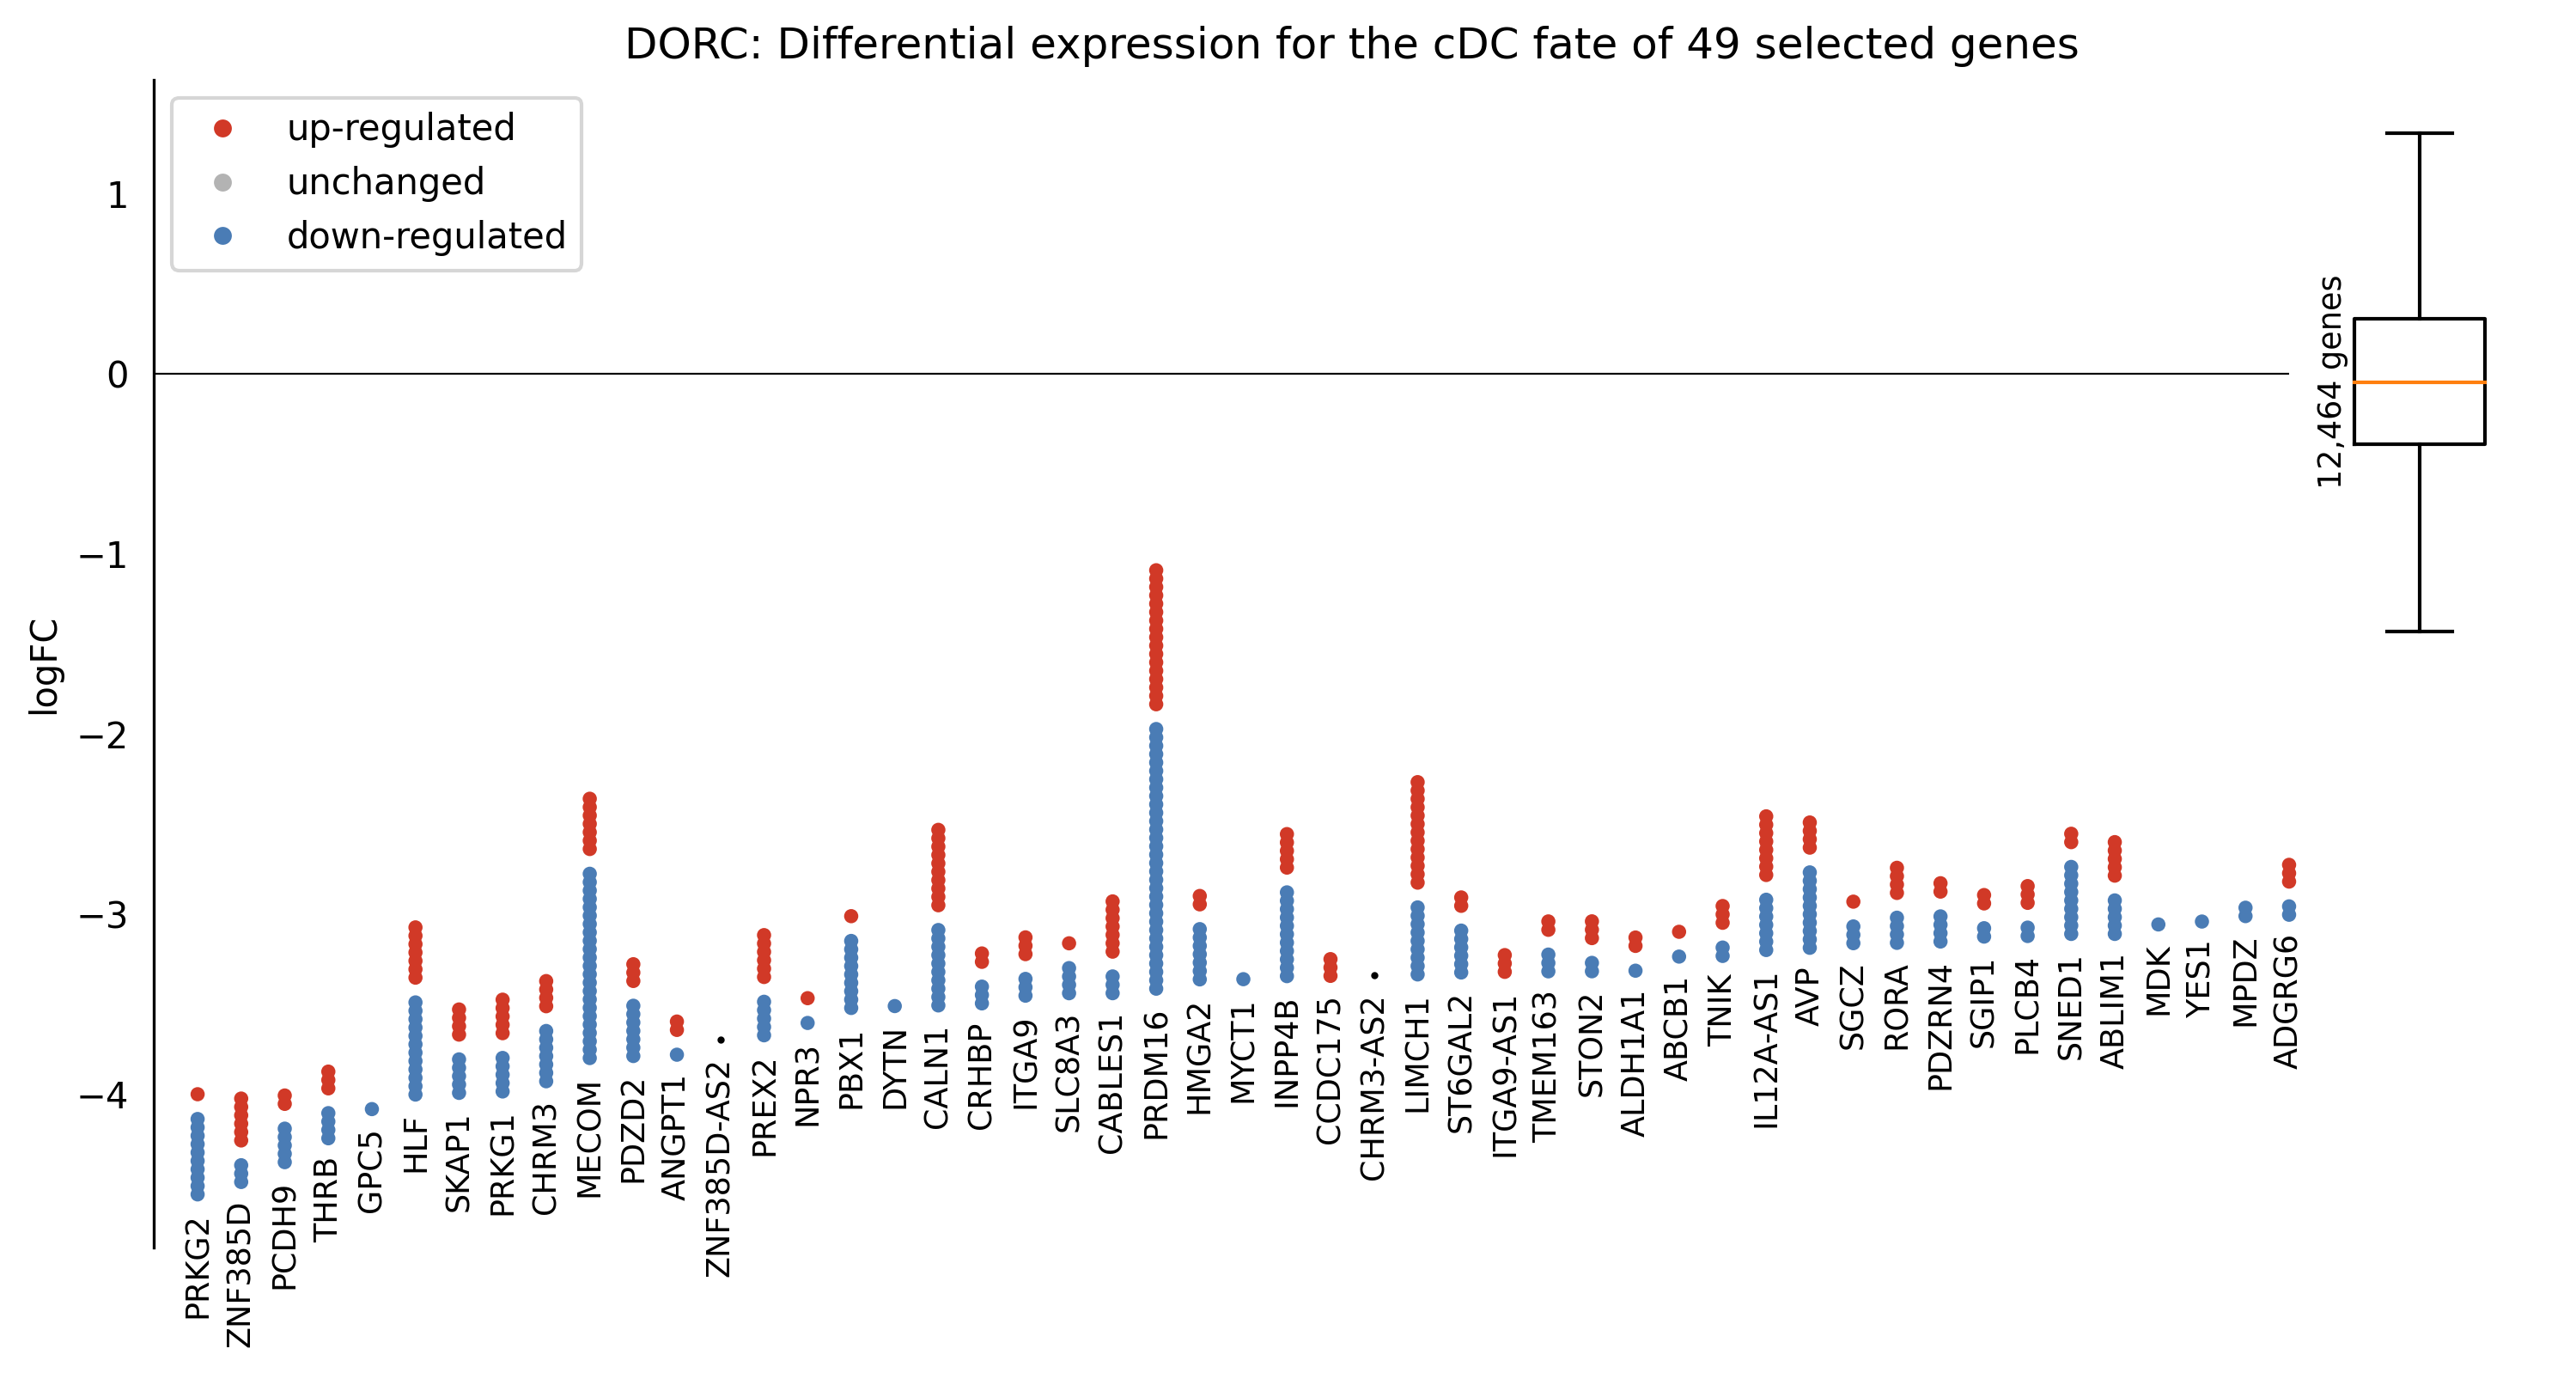

In [17]:
show_mask = gene_info_df["logFC"] < -3  # an arbitraty condition
sorted_gene_df = pd.concat(
    [gene_info_df.loc[show_mask, :], gene_info_df.loc[~show_mask, :]]
)
n_selected_genes = int(np.sum(show_mask))
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# Use alternative markers

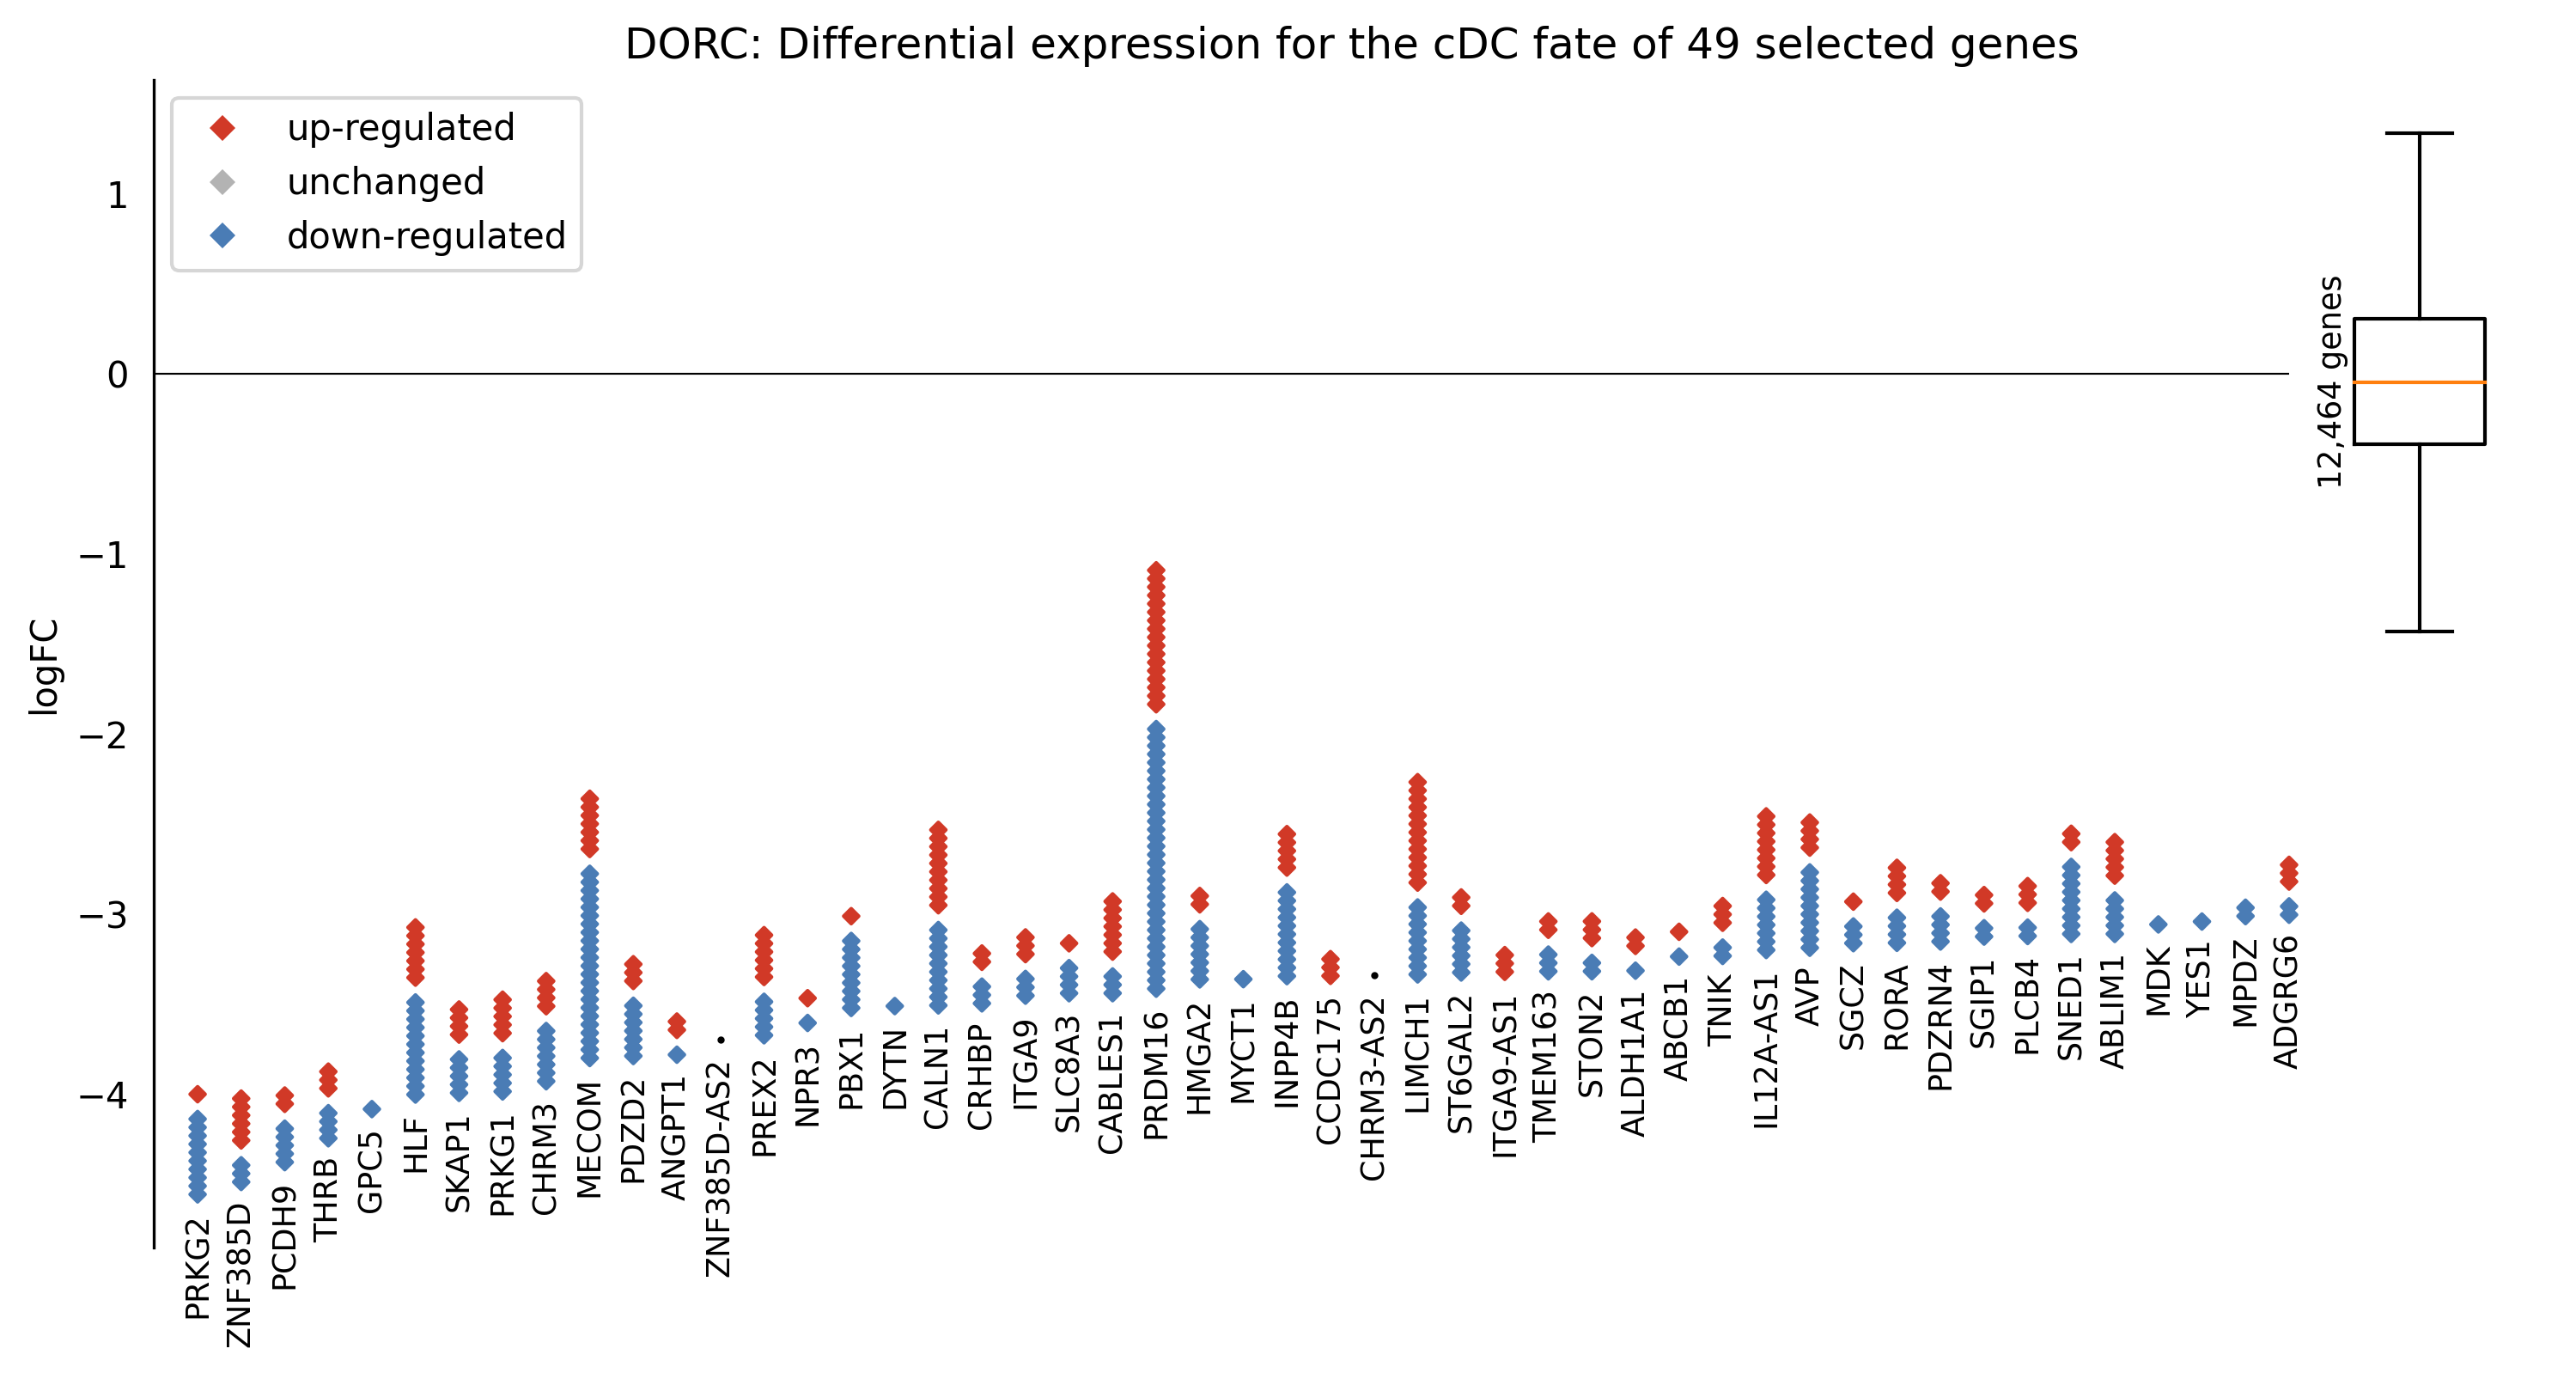

In [18]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# More space between markers

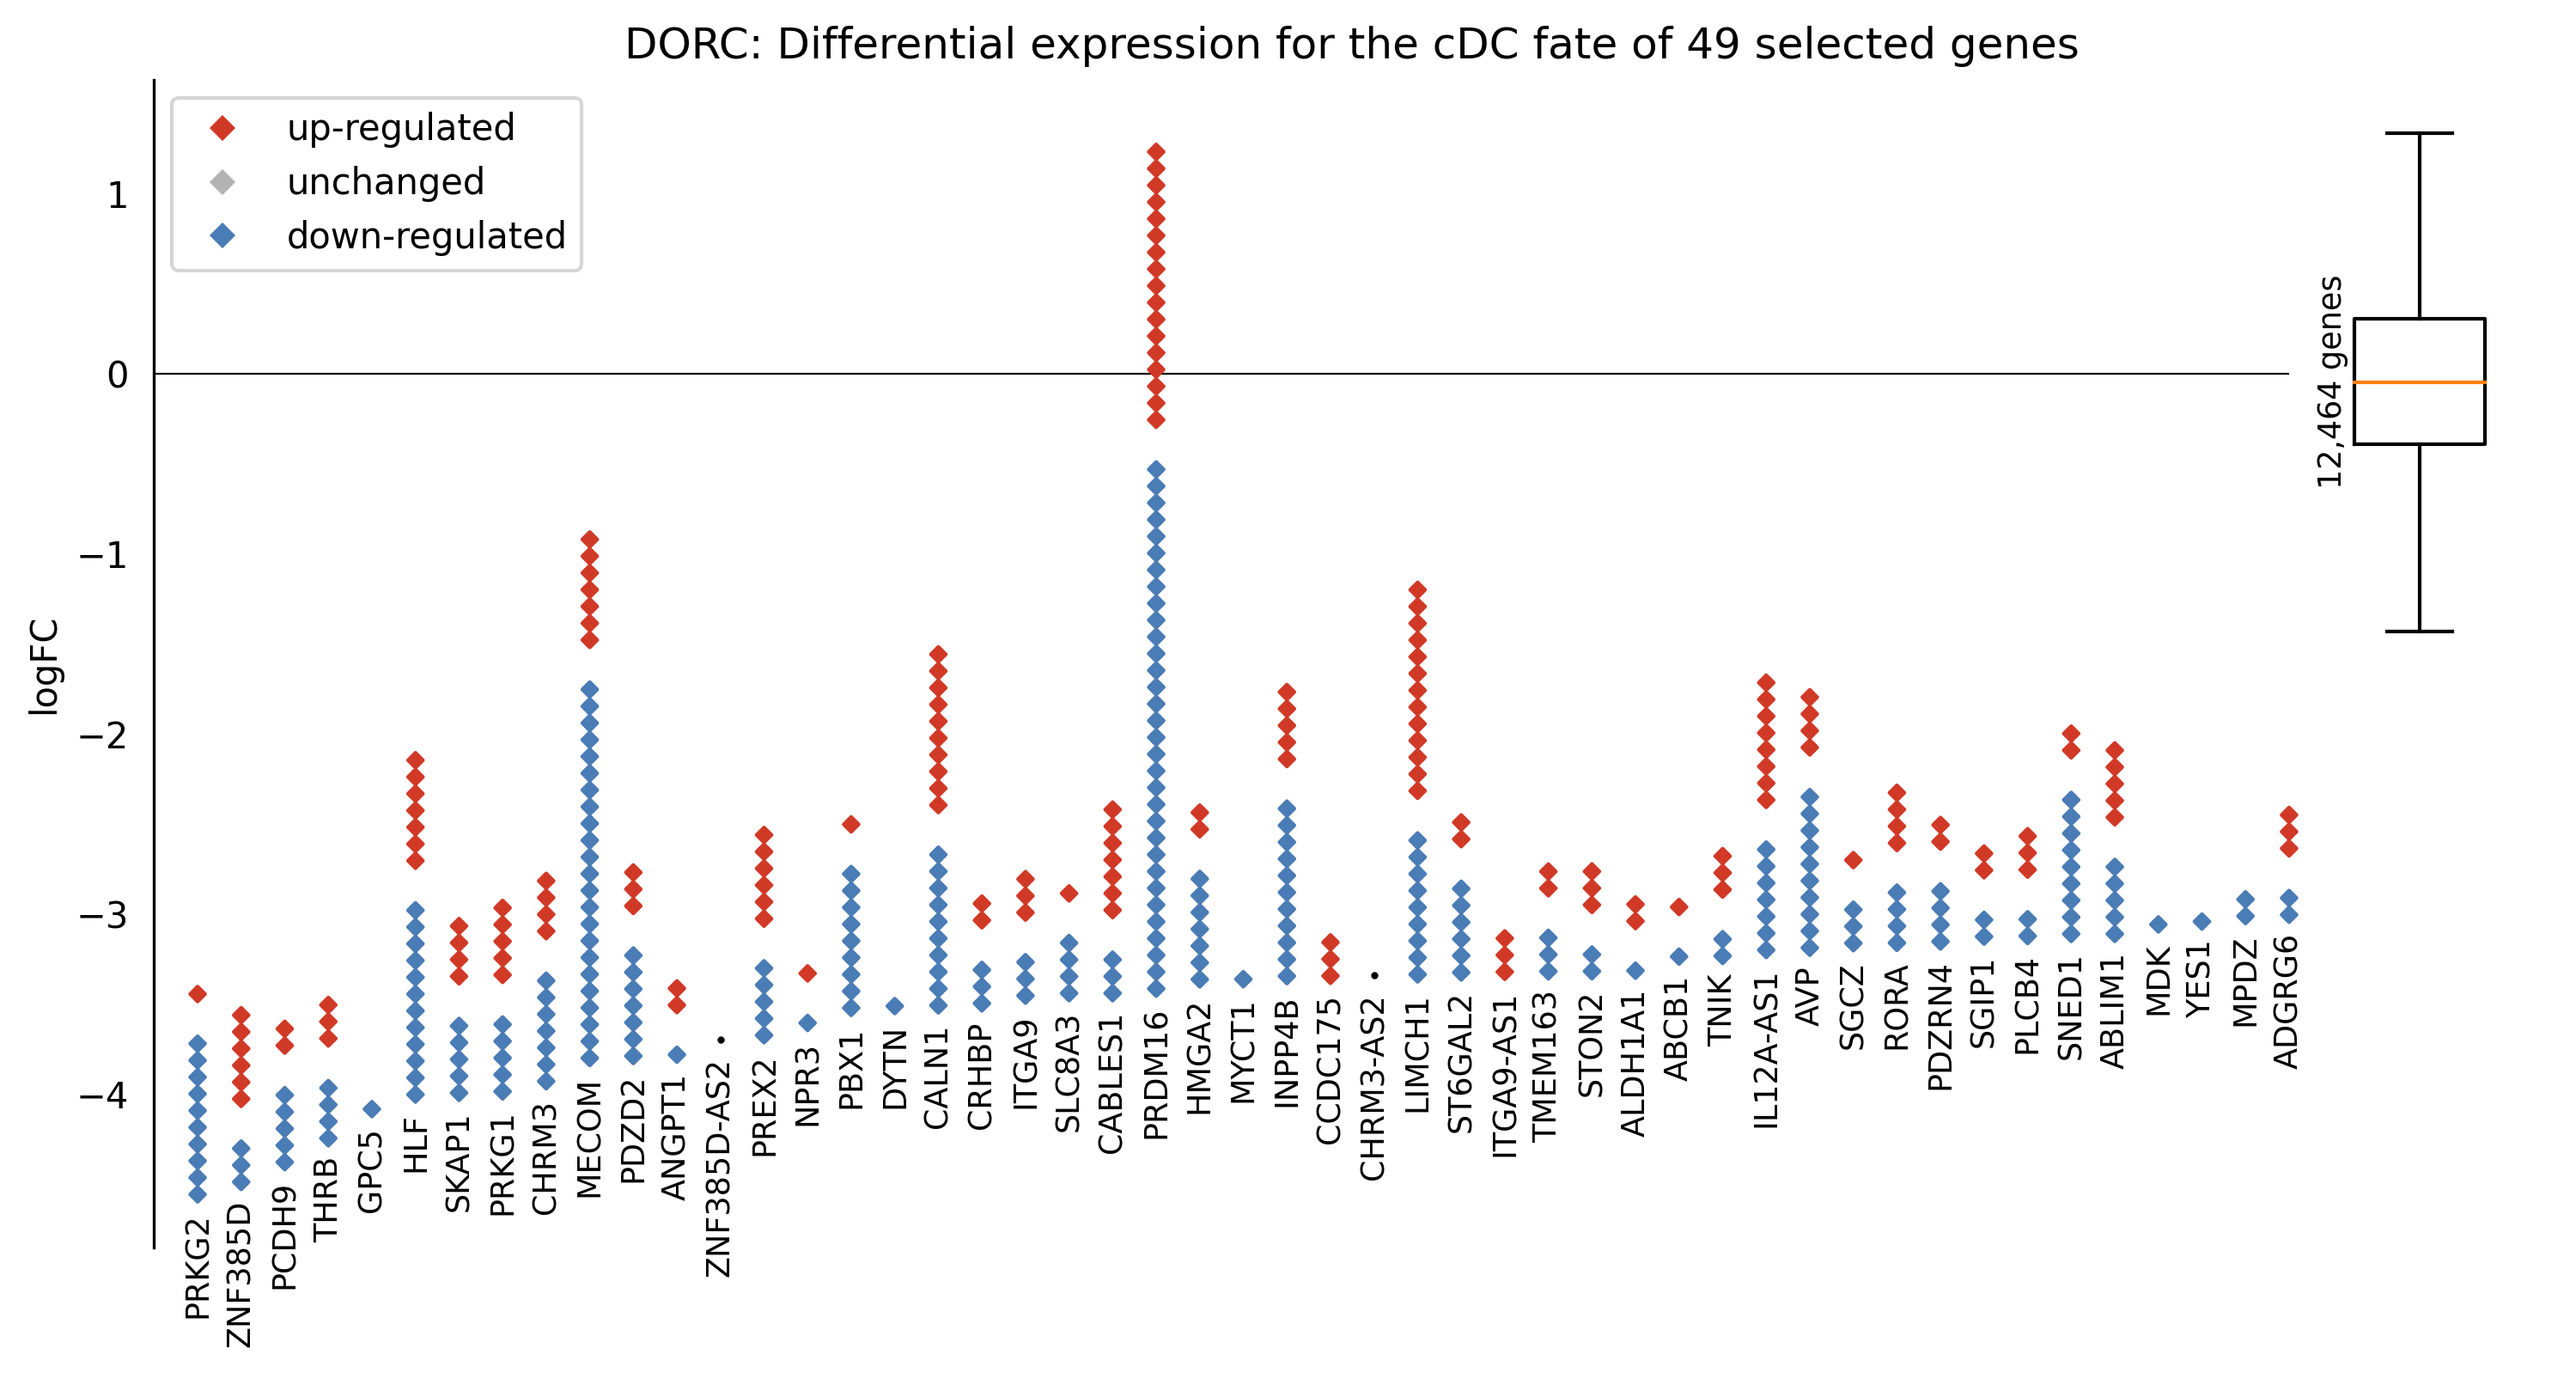

In [19]:
cmap, legend_elements = setup_cmap_and_legend(cmapdict, marker="D")
fig, ax, _ = enhancer_plot(
    sorted_gene_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_selected_genes,
    min_peaks=0,
    marker="D",
    point_distance=2e-2,
    cmap=cmap,
)
ax.legend(handles=legend_elements, loc="upper left")
ax.set_title(
    f"DORC: Differential expression for the {fate} fate of {n_selected_genes} selected genes"
)
plt.show()

# Multi subplots example

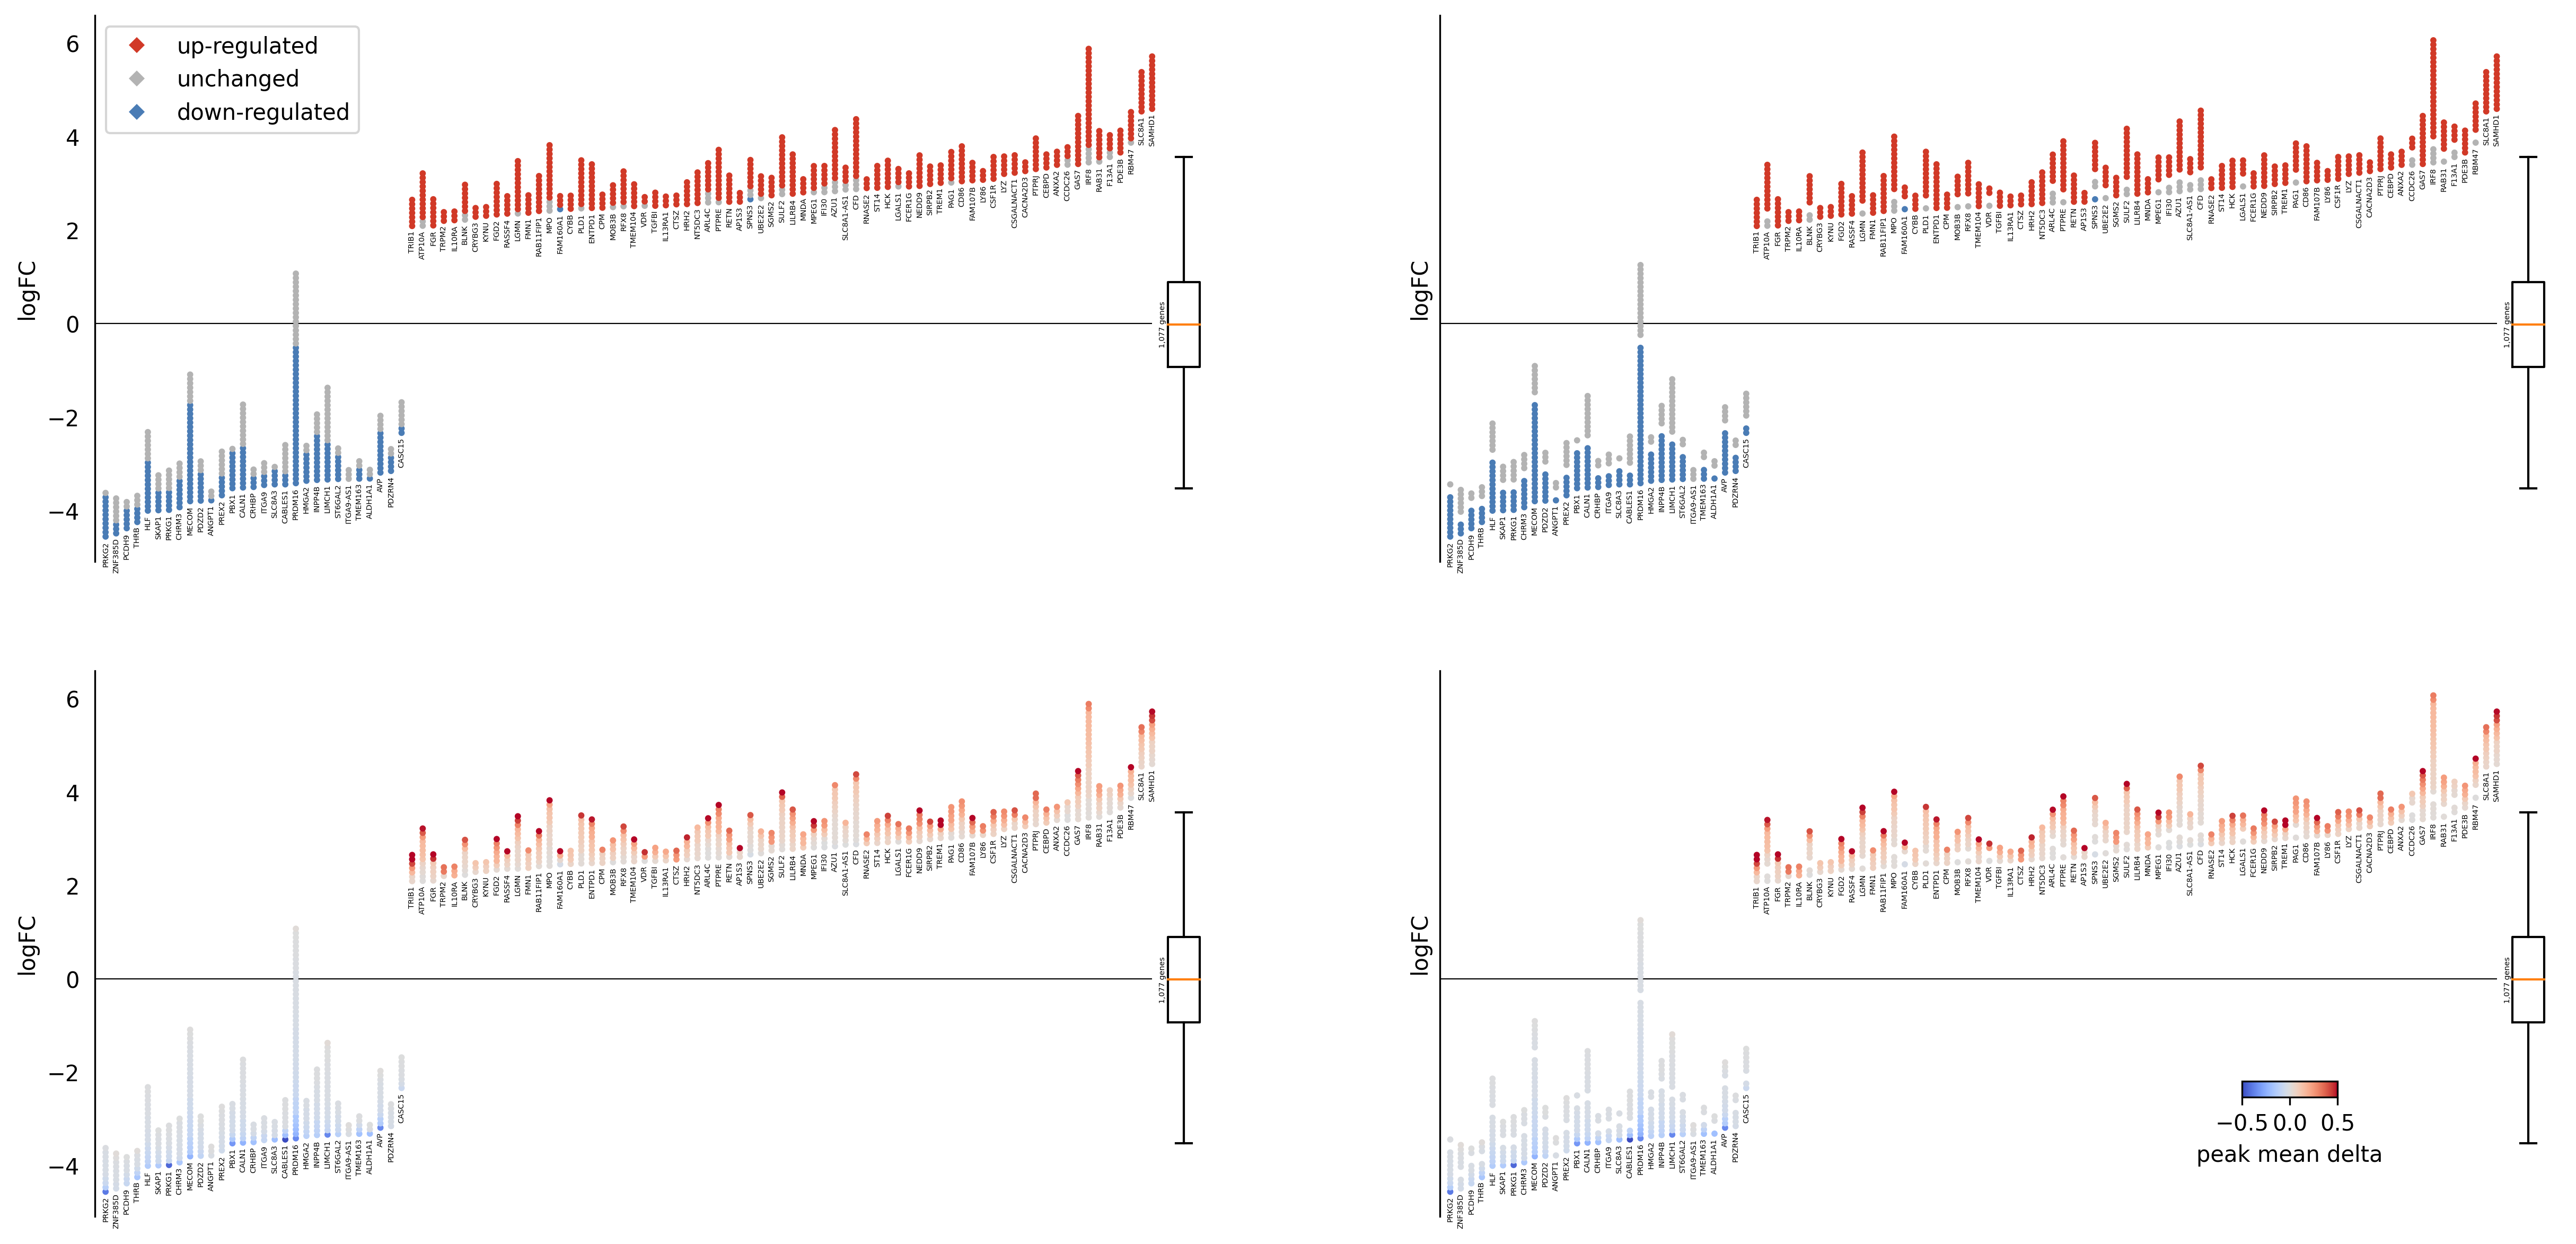

In [20]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(20, 10))

# Plot using a discrete color scheme
enhancer_plot(
    gene_info_df,
    disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 0],
)
axs[0, 0].legend(handles=legend_elements, loc="upper left")

# Plot using a continuous color scheme
enhancer_plot(
    gene_info_df,
    cont_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 0],
    color_bar_bounds=None,  # Disable colorbar
    vmin=-0.5,
    vmax=0.5,  # Normalize colors to range [-0.5, 0.5]
)

# Plot using a discrete color scheme and grouping the points
enhancer_plot(
    gene_info_df,
    disc_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    cmap=cmap,
    ax=axs[0, 1],
)

# Plot using a continuous color scheme and grouping the points
fig, ax, points = enhancer_plot(
    gene_info_df,
    cont_colors,
    peak_groups=disc_colors,
    n_genes=n_genes,
    min_peaks=min_peaks,
    ax=axs[1, 1],
    color_bar_bounds=None,
    vmin=-0.5,
    vmax=0.5,
)

# Add a colorbar in the bottom right corner
cbar_axes = fig.add_axes([0.8, 0.2, 0.03, 0.01])
cbar = fig.colorbar(points, cax=cbar_axes, orientation="horizontal")
cbar.set_label("peak mean delta")

plt.show()